Epoch 1/20


C:\Users\s27753\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0175 - val_loss: 0.0044
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 9/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 11/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 12/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

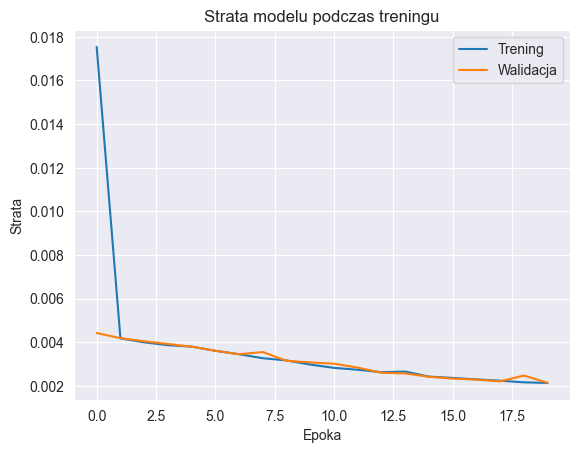

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


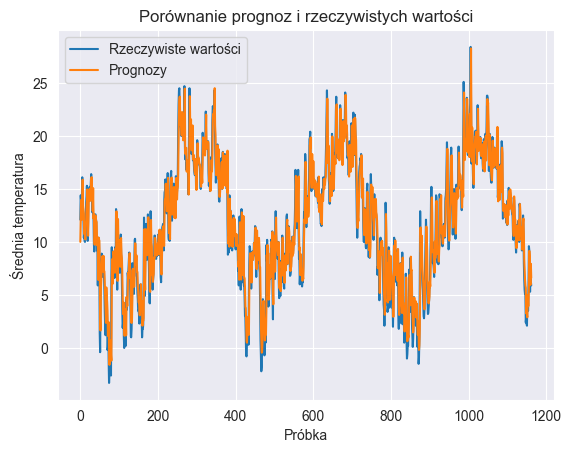

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prognozy na 5 dni do przodu (średnia temperatura):
[[6.6135464]
 [6.9104395]
 [7.118707 ]
 [7.32954  ]
 [7.4844937]]


In [24]:
from pprint import pprint

import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt


df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])


df_city = df[df['city'] == 'Warszawa']


df_city = df_city[['date', 'city', 'tavg']]


df_city.sort_values(by=["date"], inplace=True)


def create_sequences(df, window=5):

    sequences = []

    labels = []

    for i in range(len(df) - window):

        seq = df.iloc[i:i+window]['tavg'].values

        label = df.iloc[i+window]['tavg']  # Temperatura na 6. dzień

        sequences.append(seq)

        labels.append(label)

    return np.array(sequences), np.array(labels)


sequences, labels = create_sequences(df_city, window=5)


scaler = MinMaxScaler()


sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)

labels_scaled = scaler.transform(labels.reshape(-1, 1))

# Reshape do LSTM: (sample, time_steps, features)

sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# Podział na dane treningowe i testowe

train_size = int(len(sequences_scaled) * 0.8)

X_train, X_test = sequences_scaled[:train_size], sequences_scaled[train_size:]

y_train, y_test = labels_scaled[:train_size], labels_scaled[train_size:]

# Budowanie modelu LSTM

model = Sequential()

model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Trenowanie modelu

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Wizualizacja straty

plt.plot(history.history['loss'], label='Trening')

plt.plot(history.history['val_loss'], label='Walidacja')

plt.legend()

plt.title("Strata modelu podczas treningu")

plt.xlabel("Epoka")

plt.ylabel("Strata")

plt.show()

# Predykcja

predictions = model.predict(X_test)


predictions_rescaled = scaler.inverse_transform(predictions)

y_test_rescaled = scaler.inverse_transform(y_test)

# Wykres predykcji vs. realne wartości

plt.plot(y_test_rescaled, label='Rzeczywiste wartości')

plt.plot(predictions_rescaled, label='Prognozy')

plt.legend()

plt.title("Porównanie prognoz i rzeczywistych wartości")

plt.xlabel("Próbka")

plt.ylabel("Średnia temperatura")

plt.show()

# ---- PROGNOZA NA 5 DNI W PRZYSZŁOŚĆ ----

future_predictions = []

input_sequence = X_test[-1]  # (5, 1)

for _ in range(5):

    pred_scaled = model.predict(input_sequence.reshape(1, 5, 1))

    future_predictions.append(pred_scaled[0][0])

    # przesuwanie okna

    input_sequence = np.roll(input_sequence, -1)

    input_sequence[-1] = pred_scaled

# Odwrócenie normalizacji

future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Prognozy na 5 dni do przodu (średnia temperatura):")

print(future_predictions_rescaled)



In [25]:
print(model.summary)

<bound method Model.summary of <Sequential name=sequential_19, built=True>>


C:\Users\s27753\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE dla foldu 1: 3.4787185836727277


C:\Users\s27753\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE dla foldu 2: 3.6802290427882465


C:\Users\s27753\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE dla foldu 3: 3.8417493409501264


C:\Users\s27753\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE dla foldu 4: 3.4310776661656


C:\Users\s27753\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE dla foldu 5: 3.45734796549235

Średni MSE z cross-validation: 3.5778245198138103


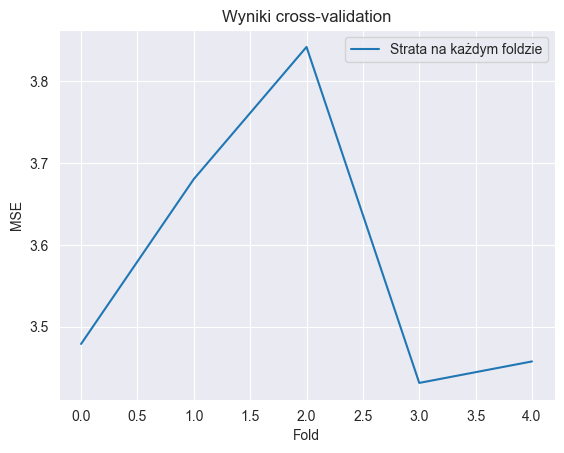

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Wczytanie danych
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])

# Filtracja danych tylko dla jednego miasta (np. Warszawa)
df_city = df[df['city'] == 'Warszawa']

# Wybór kolumn: data, miasto, średnia temperatura
df_city = df_city[['date', 'city', 'tavg']]

# Sortowanie danych według daty
df_city.sort_values(by=["date"], inplace=True)

# Funkcja do tworzenia sekwencji danych
def create_sequences(df, window=5):
    sequences = []
    labels = []

    for i in range(len(df) - window):
        seq = df.iloc[i:i+window]['tavg'].values
        label = df.iloc[i+window]['tavg']  # Temperatura na 6. dzień
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# Przygotowanie sekwencji
sequences, labels = create_sequences(df_city, window=10)  # Zwiększenie okna do 10 dni

# ---- POPRAWIONA NORMALIZACJA ----
scaler = MinMaxScaler()

# Skalowanie sekwencji (osobno dla każdej cechy)
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
labels_scaled = scaler.transform(labels.reshape(-1, 1))

# Reshape do LSTM: (sample, time_steps, features)
sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# TimeSeriesSplit dla cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # 5-fold cross-validation
val_scores = []  # Lista do przechowywania wyników walidacji

# Cross-validation
for train_index, val_index in tscv.split(sequences_scaled):
    # Dzielimy dane na zbiór treningowy i walidacyjny
    X_train, X_val = sequences_scaled[train_index], sequences_scaled[val_index]
    y_train, y_val = labels_scaled[train_index], labels_scaled[val_index]

    # Budowanie modelu LSTM z poprawkami
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Więcej jednostek
    model.add(Dropout(0.2))  # Dropout, aby zapobiec przeuczeniu
    model.add(LSTM(units=50, return_sequences=False))  # Druga warstwa LSTM
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Trenowanie modelu
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Predykcja na zbiorze walidacyjnym
    predictions = model.predict(X_val)

    # Odwracanie normalizacji
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_val_rescaled = scaler.inverse_transform(y_val)

    # Obliczenie MSE na zbiorze walidacyjnym
    mse = mean_squared_error(y_val_rescaled, predictions_rescaled)
    val_scores.append(mse)

    print(f'MSE dla foldu {len(val_scores)}: {mse}')

# Średnia wartość MSE z cross-validation
mean_mse = np.mean(val_scores)
print(f'\nŚredni MSE z cross-validation: {mean_mse}')

# Wizualizacja strat
plt.plot(val_scores, label='Strata na każdym foldzie')
plt.legend()
plt.title("Wyniki cross-validation")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.show()
